# MCMC On Posteriors With Improper Priors

MCMC (Markov Chain Monte Carlo) requires a posterior probability distribution to sample from.
This means that one cannot sample from a likelihood, if one wishes to sample the parameters of a model. This is because the likelihood is a probability distribution of the *data*, conditioned on the parameters, rather than a probability distribution of the parameters. If our goal were to sample data sets, given a set of parameters we know to be true, the likelihood would be the right function to use.
However, most inference problems in science are concerned with sampling the parameters of a model, which presumably hold some information of interest about the underlying process that generated the data.

Even so, in many applications, researchers specify the likelihood and then use MCMC to infer the distribution of the parameters, without explicitly specifying the prior. But that doesn't mean the model is without prior. In fact, it cannot be in order for MCMC to work. The implicit assumption in this case is that the priors are flat (all values of the parameters are equally probable) and infinite. This runs the risk of making the posterior improper, that is, diverging, so that it does not integrate to 1. This is in general a bad property to have for a probability distribution, and for MCMC in particular. It's worth noting that this doesn't have to be true: if the likelihood function is well behaved, the posterior might still integrate to 1 even if the prior is improper. The key thing here is that this needs to be checked; for complex problems, this might be hard to do.

Here, I advocate that explicitly specifying the prior is always a good idea, and try to show some ways where not specifying priors can go very wrong.

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy.stats

## Exponential likelihoods

Brendon Brewer tells me that exponential likelihood are Bad when no prior is specified. Let's play around with this!

First, let's make some data. We're going to have a Gaussian with two parameters: location and scale.


In [72]:
x = np.linspace(0, 1, 1000, endpoint=False)

In [73]:
true_loc = 0.5
true_scale = 0.06
y = scipy.stats.norm(true_loc, true_scale).pdf(x)

<IPython.core.display.Javascript object>


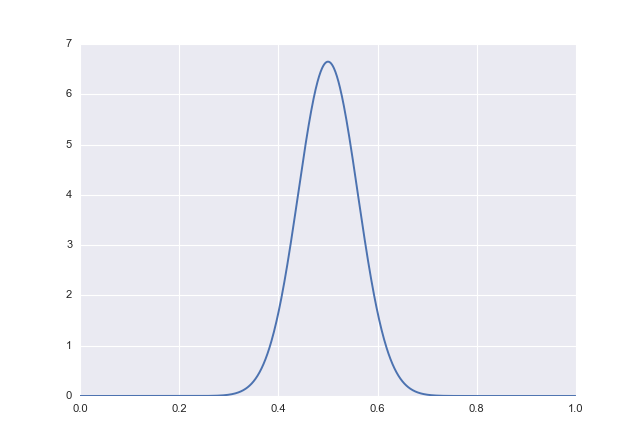

In [74]:
plt.figure()
plt.plot(x, y)

Okay, we're going to have a sampling distribution that's an exponential around the mean model:

In [69]:
ydata = y + np.random.exponential(scale=0.5, size=x.shape[0])

<IPython.core.display.Javascript object>


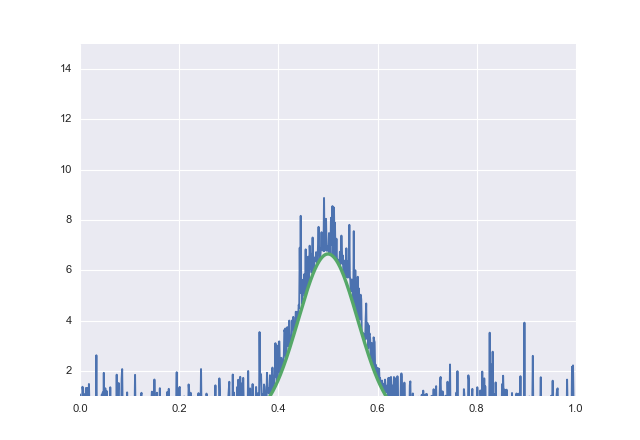

(1.0, 15.0)

In [75]:
plt.figure()
plt.plot(x, ydata)
plt.plot(x, y, lw=3)
plt.ylim(1.0, 15.0)

In [34]:
class Likelihood(object):
    
    def __init__(self, x, y, model, m=2.0):
        """
        A likelihood class.
        
        Parameters
        ----------
        x : numpy.ndarray
            The independent variable of the data
        
        y : numpy.ndarray
            The dependent variable of the data
            
        model : function
            A model function f(x, parameters), where, parameters is 
            an iterable with parameters.
            
        m : int (optional)
            The scale of the exponential.
        
        """
        self.x = x
        self.y = y
        self.n = self.x.shape[0]
        self.model = model
        
    def loglikelihood(self, pars):
       
        mean_model = self.model(self.x, pars)
        
        loglike = self.n*np.log(m) - m*np.sum(self.y-mean_model)
        
        return loglike
    
    def __call__(self, pars):
        return self.loglikelihood(pars)
    

Okay, now all we have to do is define a model, and then we can compute the likelihood:

In [76]:
mean_model = lambda x, c: scipy.stats.norm(c[0], c[1]).pdf(x)

What's the likelihood like?

In [77]:
loglike = Likelihood(x, ydata, mean_model)

In [80]:
loglike([0.1, 0.1])

-702.69189995902445

Let's make a simple grid of the likelihood in order to be able to print it:

In [ ]:
test_pars = np.logspace(0.001, 100, num=10000, endpoint=False)
likelihood_grid = np.zeros((len(test_pars), len(test_pars)))

for i,t1 in enumerate(test_pars):
    for j,t2 in enumerate(test_pars):
        likelihood_grid[i,j] = loglike([t1, t2])
